# 0.0 Imports

In [1]:
import numpy as np
import pandas as pd

from IPython.display import Image

## 0.1 Load data

In [2]:
variable_filtering = catalog.load("variable_filtering")

[09/23/23 16:53:50] INFO     Loading data from 'variable_filtering' (CSVDataSet)...             ]8;id=329068;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=900384;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#492\492]8;;\

## 0.2 Helper Functions

In [3]:
def notebook_settings():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', 80)
    pd.set_option('display.float_format', lambda x: '%.3f' % x)

    return None


def split_and_count(df, column_name, new_column_name=None):
    """Split a string column and count the number of elements."""
    new_column_name = new_column_name or f'number_of_{column_name}s'
    df[new_column_name] = df[column_name].str.split(',').str.len()


def get_element_film_counts(feature_engineering, column):
    """Count the occurrences of each unique item in a list column."""
    directors = feature_engineering.explode(column)
    films_by_director = directors[column].value_counts().to_dict()
    return films_by_director


def calculate_mean_film_counts(feature_engineering, column, count_films):
    """Compute the mean of film counts for items in a list column."""
    return (feature_engineering[column]
            .apply(lambda x: np.mean([count_films[i] for i in x])
                    if isinstance(x, list) else 0))


def calculate_mean_film_counts_with_split(feature_engineering, column, count_films):
    """Split the string column into a list and compute the mean of film counts for items."""
    feature_engineering[column + '_list'] = feature_engineering[column].str.split(',')
    return (feature_engineering[column + '_list'].apply(lambda x: 
                                                      np.mean([count_films.get(country.strip(), 0)
                                                                for country in x if x is not np.nan])))


notebook_settings()

# 3.0 Feature Engineering

In [4]:
feature_engineering = variable_filtering.copy()

feature_engineering.head()

,show_id,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019-09-09,2019,41,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Jandino: Whatever it Takes,others_directors,Jandino Asporaat,United Kingdom,2016-09-09,2016,52,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,80125979,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,2017-09-08,2017,57,99 min,Comedies,When nerdy high schooler Dani finally attracts...
3,70304989,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada",2017-09-08,2014,61,110 min,"International Movies, Sci-Fi & Fantasy, Thrillers","In a dystopian future, an insurance adjuster f..."
4,80164077,Fabrizio Copano: Solo pienso en mi,"Rodrigo Toro, Francisco Schultz",Fabrizio Copano,Chile,2017-09-08,2017,49,60 min,Stand-Up Comedy,Fabrizio Copano takes audience participation t...


## 3.1 MindMap Hypothesis

- The mind map helps us explore the data and identify potential features that have not been collected, to avoid bias the map tends to be built before observing the data

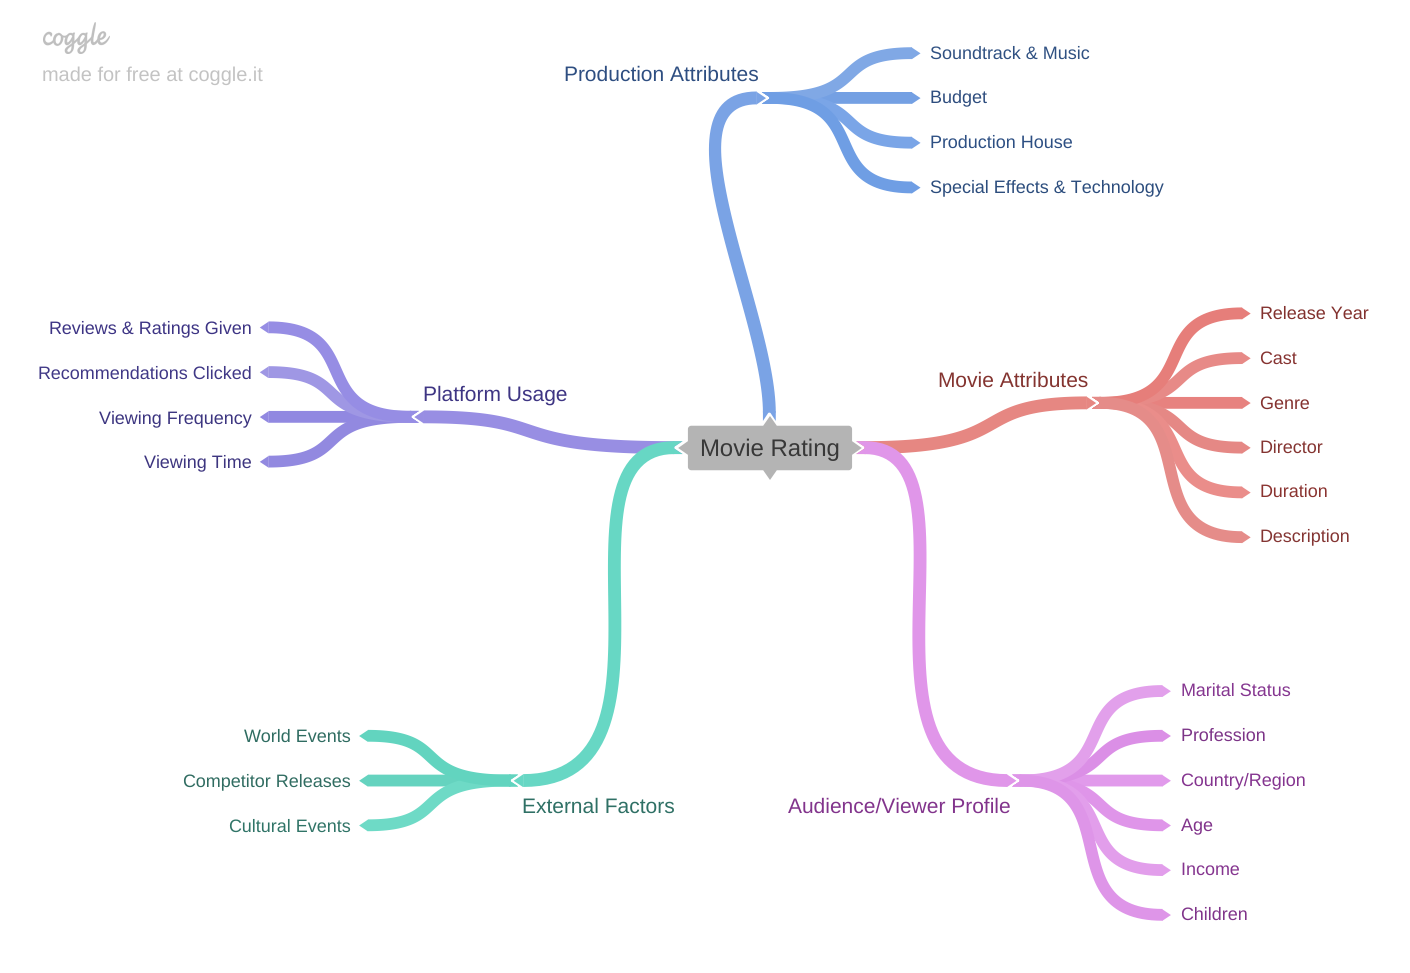

In [5]:
Image('../docs/movie_rating_mindmap.png')

- To avoid endless exploratory analysis, we will define several hypotheses and prioritize those that we have data on and that have potential for insight.

### 3.1.1 Creating hypotheses

---

### Feature 1: **Movie Attributes**

1. **Genre**: Action films have an average rating 10% higher than comedy films.
2. **Director**: Films directed by directors who have released more than 5 films have an average rating 15% higher than those directed by directors with less than 5 films.
3. **Cast**: Films with casts that have appeared in more than 10 listed films have an average rating 10% higher.
4. **Duration**: Films lasting more than 120 minutes have an average rating 5% lower than shorter films.
5. **Release Year**: Films released after the year 2000 have an average rating 10% higher than films released before 2000.
6. **Description**: Movies with descriptions containing the keyword "thriller" have a rating median that's 10% higher than those with the keyword "romance".

---

### Feature 2: **Audience/Viewer Profile**

1. **Country/Region**: Movies preferred in Western regions have a rating average that's 15% higher than those preferred in Eastern regions.
2. **Age**: Movies preferred by viewers aged 18-25 have a rating median that's 10% higher than those preferred by viewers aged 50 and above.
3. **Profession**: Movies preferred by tech professionals have a rating mode that's 20% higher for sci-fi genres than romantic genres.
4. **Income Level**: Movies preferred by high-income viewers have a rating average that's 15% higher than movies preferred by low-income viewers.
5. **Marital Status**: Movies preferred by single viewers have a rating median that's 10% higher than those preferred by married viewers.
6. **Children**: Movies preferred by viewers without children have a rating mean that's 5% higher than movies preferred by viewers with children.

---

### Feature 3: **Platform Usage Metrics**

1. **Viewing Frequency**: Movies watched by frequent viewers have a rating mode that's 10% higher than those watched occasionally.
2. **Viewing Time**: Movies watched for more than 2 hours consecutively have a rating average that's 10% higher than movies watched in shorter intervals.
3. **Recommendations Clicked**: Movies that are often clicked from recommendations have a rating median that's 15% higher than those discovered by searches.
4. **Reviews & Ratings Given**: Movies with higher frequency of reviews have a rating mean that's 10% higher than movies with fewer reviews.

---

### Feature 4: **External Factors**

1. **Competitor Releases**: Movies that have no major competitor releases in the same week have a rating average that's 10% higher.
2. **Cultural Events**: Movies released during Christmas have a rating median that's 15% higher than those released in non-holiday periods.
3. **World Events**: Movies with themes related to real-world events have a rating mode that's 10% higher in the year of the event.

---

### Feature 5: **Production Attributes**

1. **Budget**: High budget films have a rating mean that's 20% higher than low budget films.
2. **Production House**: Movies from renowned production houses have a rating median that's 15% higher than lesser-known production houses.
3. **Soundtrack & Music**: Movies with hit songs have a rating mode that's 10% higher than movies without hit songs.
4. **Special Effects & Technology**: Films released after 2010 and classified as "Sci-Fi" have an average rating 10% higher.

### 3.1.6 Final list of hypotheses

- `The final list of hypotheses takes into account the expectation of generating insights together with the availability of data`


1. **Genre**: Action films have an average rating 10% higher than comedy films.
2. **Director**: Films directed by directors who have released more than 5 films have an average rating 15% higher than those directed by directors with less than 5 films.
3. **Cast**: Films with casts that have appeared in more than 10 listed films have an average rating 10% higher.
4. **Duration**: Films lasting more than 120 minutes have an average rating 5% lower than shorter films.
5. **Release Year**: Films released after the year 2000 have an average rating 10% higher than films released before 2000.
6. **Special Effects & Technology**: Films released after 2010 and classified as "Sci-Fi" have an average rating 10% higher.

## 3.2 Feature Engineering

Defining films in [short, medium and feature length](https://www.cinemaepipoca.com.br/curta-media-e-longa-metragem-quais-diferencas/)

In [6]:
# Derive duration features for minutes
feature_engineering['minutes'] = feature_engineering['duration'].str.extract('(\d+) min').fillna(0).astype(int)
feature_engineering.drop(columns=['duration'], inplace=True)
feature_engineering['duration_bins'] = pd.cut(feature_engineering['minutes'], bins=[0, 40, 70, np.inf], labels=['short', 'medium', 'long'])

# Calculate movie age
feature_engineering['years_since_release'] = feature_engineering['date_added'].dt.year - feature_engineering['release_year']

# Infer whether long or short descriptions are important
feature_engineering['description_length'] = feature_engineering['description'].apply(len)

# Evaluate the film's development stage
feature_engineering['movie_stage'] = np.where(feature_engineering['date_added'].dt.year <= feature_engineering['release_year'], 'Development', 'Released')

# Splitting columns into lists
col_mapping = {
    'director': 'director_list',
    'cast': 'cast_list',
    'country': 'country_list',
    'listed_in': 'genre_list'
}

for col, new_col in col_mapping.items():
    feature_engineering[new_col] = feature_engineering[col].str.split(',')
    split_and_count(feature_engineering, col)

# Calculating the average number of films for each director, cast member, country and genre
films_by_director = get_element_film_counts(feature_engineering, 'director_list')
films_by_cast_member = get_element_film_counts(feature_engineering, 'cast_list')
feature_engineering['films_by_director'] = calculate_mean_film_counts(feature_engineering, 'director_list', films_by_director)
feature_engineering['films_by_cast_member'] = calculate_mean_film_counts(feature_engineering, 'cast_list', films_by_cast_member)

country_film_count = get_element_film_counts(feature_engineering, 'country')
feature_engineering['films_per_country'] = calculate_mean_film_counts_with_split(feature_engineering, 'country', country_film_count)

genre_film_count = get_element_film_counts(feature_engineering, 'listed_in')
feature_engineering['films_per_genre'] = calculate_mean_film_counts_with_split(feature_engineering, 'listed_in', genre_film_count)

# Remove temporary columns
feature_engineering.drop(columns=list(col_mapping.values()), inplace=True)

The `description` column is rich in textual information and can be explored in various ways to extract relevant characteristics, however this involves the use of analysis and deeplearning algorithms which takes up considerable time, so we can consider using it for a next cycle.

In [7]:
catalog.save("feature_engineering", feature_engineering)

                    INFO     Saving data to 'feature_engineering' (CSVDataSet)...               ]8;id=174331;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=242177;file://f:\SamuelOliveiraAlvesd\Anaconda3\envs\netflix_classifier\Lib\site-packages\kedro\io\data_catalog.py#531\531]8;;\